# Total Dataset mining

In [1]:
import pandas as pd 
import numpy as np
from datetime import date,datetime
import csv
import re
from multiprocessing import Pool
from functools import partial
from sklearn import preprocessing
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import itertools
import os
import json
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

In [43]:
# TODO add doc 
def dataset_property_split(df,frequency,properties,min_support,groupby_property="CUST_ID",itemset_property="ARTICLE_ID",temp_folder="../lcm_temp",indexation_folder="../index"):
    """Split dataset """
    for period,i in df.groupby(pd.Grouper(freq = frequency)):
        for values,ii in i.groupby(properties):
            if len(properties)>1:
                values = '_'.join(str(z) for z in values)
            
            split_name = f"{temp_folder}/{period}_{values}#{min_support}"
            index_file_name = f"{indexation_folder}/{period}_{values}#{min_support}"

            ii = ii.groupby(groupby_property)[itemset_property].apply(lambda x: " ".join(str(z) for z in x))
            
            ii.to_csv(split_name,index=None,header=False)
            pd.DataFrame(ii.index).to_csv(index_file_name,header=False,index=None)
            yield str(split_name)
        

def preprocessing_similar_ids(df,mapping_file_path="../datasets/Total/ids_mapping.json",attribute_name="ARTICLE_ID"):
    with open(mapping_file_path,"r") as f:
        mapping = json.load(f)
        ids = df[attribute_name].astype(str).replace(mapping)
    return ids
def reformat_output(unformated_result,split_name,index_folder="../index"):
    """
    Reformat default output of lcm  to a dataframe with structure : min_support,itemsets,users
    """
    output = pd.DataFrame([unformated_result[0::2],unformated_result[1::2]]).T
    output = pd.concat([output.drop(0,axis=1),output[0].str.split('\(([0-9]+)\)',expand=True).drop(0,axis=1)],axis=1)
    split_name= split_name.split("/")[2] #remove temp folder from name
    output["period"] = split_name.split("_")[0]
    output["property_values"] = "_".join(split_name.split("_")[1:]).split("#")[0]
    output.columns = ["CUST_ID","support","itemset","period","property_values"]
    indexes = pd.read_csv(f'{index_folder}/{split_name}',header=None)[0].to_dict()
    output["CUST_ID"]= output["CUST_ID"].map(lambda x : [indexes[int(i)] for i in x.split()])
    return output


# TODO doc for support
def run_lcm(split_name,itemsets_size,support,output_file):
    """Runs LCM (Single Thread)  and return the  result formated with format_output
    
    Example for parameters : input_file='1999',support=6, itemsets_size=[5,100]
    Executed command :  $ ./lcm C_QI -l 5 -u 100 1999 6 -
    
    Preconfigured parameters:  
     C: enumerate closed frequent itemsets
     M: enumerate maximal frequent itemsets 
     Q: output the frequency on the head of each itemset found,
     I: output ID's of transactions including each itemset; ID of a transaction is given by the number of line in which the transaction is written. The ID starts from 0.
     _: no output to standard output (including messages w.r.t. input data)
     -l,-u [num]: enumerate itemsets with size at least/most [num]  
   
    Output:
        Replace file having name input_file with the result : support,itemset,users
        if no itemset found the input_file is deleted and output is empty string ""
    """
    support = int(support)
    result = !./lcm C_QI -l {itemsets_size[0]} -u {itemsets_size[1]}  {split_name} {support} -
    os.remove(split_name)
    if "there is no frequent item" in str(result) or result == []:
        print("No itemset",split_name)
        return 
    print("Found ",len(result)/2," in",split_name )
    # TODO Optimize this bottleneck 
    with open(output_file,"a+") as file:
        reformat_output(result,split_name).to_csv(file,header=False,index=None,mode="a")
    return split_name


def multithread_lcm(input_file,frequency,support,itemsets_size,properties,output_file):
    f = partial(run_lcm,itemsets_size=itemsets_size,support=support, output_file=output_file)
    p = Pool(1)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,support))
    p.close()
    p.join()
    return res
                                              
def linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties):
    output_file = f'../lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
    try:
        os.remove(output_file) # In case already existing
        print(f"Removed old {output_file}")
    except:
        print(f"No old file to remove for {output_file} ")
        pass
    a = multithread_lcm(df,frequency,min_support,itemsets_size,properties,output_file)
    total  = len(a._items)
    print(a,total)
    a = [i for i in a if i is not None]
    print(f"---| {output_file} Done")
    print(f'---| #split total: {total}')
    print(f'---| #split having groups: {len(a)}')
    print(f'---| Average: {len(a)/total}')
    print(" ")
    
    
def age_class(age):
    """User age to range classes """
    age = np.int(age)
    if age<=25:
        return 0
    if age<=45:
        return 1
    return 2
def prepare_data(file_name,folder_name="datasets/Total/data/"):
    df = pd.read_csv(f"datasets/Total/data/{file_name}",sep=";")
    df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    return df

def read_lcm_output_total(input_name,folder="../lcm_results"):
    """Read and restructure LCM output file,rename columns output a df """
    file = f'{folder}/{input_name}'
    df = pd.read_csv(file,header=None)
    df.columns = ["user_ids","support","itemsets","period","property_values"]
    df["period"] = pd.to_datetime(df["period"])
    df["user_ids"] = df.user_ids.apply(lambda x : [int(z.replace('"',"")) for z in x[1:-1].split(",") if z != ""])
    return df

### Run LCM

In [4]:
frequencies =["M","2M","3M"]
properties = [["STATION_MGT_TYPE"],["STATION_MGT_TYPE","DEPARTEMENT"]]
from itertools import product
for frequency,prop in product(frequencies,properties):
    linear_closed_itemset_miner(df,frequency,5,[2,"5000"],prop)

## LCM for total dataset with no demographics

In [7]:
import datetime
def concat_total_dataset(files_path='../datasets/Total/data'):
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df

In [16]:
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)
df["a"] = 1 # Must set a "grouping" attribute while we don't consider demographics

In [48]:
# Here we fix a small issue with LCM, on total dataset products ids are too large, so we use a label encoder
# Once done, the encoder is saved and could be restored for post processing

le = preprocessing.LabelEncoder()
df["ARTICLE_ID"] = le.fit_transform(df["ARTICLE_ID"]) 

np.save(f'{file_name}.npy', le.classes_)

In [49]:
min_support = 5
frequency = 'Y' # Time granularity could be D,3D,7D, M, 2M, Y, ...
min_description_size = 2 # the minimal number of products per group
itemsets_size = [min_description_size,"5000"]
properties =["a"] # Set this to a groupping attribute, like ["sex","age"] or ["a"] to ignore this behaviour


In [50]:
output_file = f'../lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'

In [51]:
linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties)

Removed old ../lcm_results/Y-5-[2-5000]-[a]-lcm.out
Found  4959.0  in ../lcm_temp/2017_1#5
Found  10375.0  in ../lcm_temp/2018_1#5
Found  6308.0  in ../lcm_temp/2019_1#5
<multiprocessing.pool.IMapUnorderedIterator object at 0x7f57b3c2e310> 3
---| ../lcm_results/Y-5-[2-5000]-[a]-lcm.out Done
---| #split total: 3
---| #split having groups: 3
---| Average: 1.0
 


In [52]:
result_df = read_lcm_output_total(output_file)
result_df.head()

,user_ids,support,itemsets,period,property_values
0,"[107233, 112041, 112511, 113661, 120927, 13046...",153,4125 4126,1970-01-01 00:00:00.000002017,1
1,"[103286, 106500, 111896, 112041, 112511, 11555...",255,4112 4126,1970-01-01 00:00:00.000002017,1
2,"[101392, 103371, 112041, 112384, 112511, 12219...",133,4112 4125,1970-01-01 00:00:00.000002017,1
3,"[112041, 112511, 141648, 156003, 171799, 18397...",28,4112 4125 4126,1970-01-01 00:00:00.000002017,1
4,"[126059, 206396, 287610, 299418, 341716, 50352...",10,163 4126,1970-01-01 00:00:00.000002017,1


In [58]:
# Extra step, inverse items encoding
result_df.itemsets= result_df.itemsets.apply(lambda x : le.inverse_transform([int(i) for i in x.split()]))

In [60]:
# Done :) 
result_df.to_csv(output_file)

# LCM on promotion periods

In [6]:
import datetime
def concat_total_dataset(files_path='../datasets/Total/data'):
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df

In [4]:
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)


In [13]:
df.TRANSACTION_DATE.min(),df.TRANSACTION_DATE.max(),

('2017-02-28 07:23:20', '2019-12-30 22:12:56')

In [38]:
# Global parameters
frequency ="9M"
min_support= 5
itemsets_size = [1,"2001"]
properties = ["a"]
file_name =f'{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
output_file = f'../lcm_results/{file_name}'

In [43]:
# Encoding for ARTICLE_ID as their size is not supported by current lcm implementation 
le = preprocessing.LabelEncoder()
le.fit(df["ARTICLE_ID"])
# # Encoder is saved 
np.save(f'../plots/encoders/{file_name}.npy', le.classes_)

In [44]:
promo_products

,Unnamed: 0,DESCRIPTION,IDS_LIST,ARTICLE_ID
0,121,ACTIVA 5000 ESS 15W40,[3425901014890],3425901014890
5,126,ACTIVA 9000E 1L,[3425901015859],3425901015859
6,127,ACTIVA D5000 1L 15W40,[3425901015835],3425901015835
7,128,ACTIVA D9000 5L 5W40,[3425901014944],3425901014944
8,129,ACTIVA INEO ECS 5W30 2L,[3425901018188],3425901018188
11,132,ACTIVA INEO LONG LIFE 5W30 5L,[3425901027449],3425901027449
12,160,ADBLUE BIDON 5L,"[3011449300559, 3011449300331, 3701239300004, ...",3011449300559
13,1093,BIDON AD BLUE 10L,"[3425901018140, 7070091000701, 3460537800028, ...",3425901018140
16,3944,ELF EVOLUTION 5W30 2 L,[3267025010606],3267025010606
22,3963,ELF MOTO 2 OFF ROAD 1L 10W40 SAE 30,[3267025007262],3267025007262


In [45]:
df.ARTICLE_ID

TRANSACTION_DATE
2018-07-30    3700205840780
2019-08-13     712392777322
2019-08-13    3017625073309
2018-03-26    3425909001076
2017-05-12    3425909001076
                  ...      
2017-09-01    8593893720442
2019-06-14    3217770310841
2019-06-03    3701239300011
2019-06-03    3701239300011
2019-06-03    3701239300011
Freq: D, Name: ARTICLE_ID, Length: 250208, dtype: int64

In [46]:
# Promotion product list 
promo_products = pd.read_csv("../datasets/Total/promo_products.csv")
promo_products= promo_products[promo_products["ARTICLE_ID"].isin(df.ARTICLE_ID)]
promo_list = le.transform([i for i in promo_products.ARTICLE_ID.tolist()])

In [47]:
df["ARTICLE_ID"] = le.transform(df["ARTICLE_ID"])

In [86]:
# promo dates 
promo_date_begin = pd.to_datetime(datetime.date(2018,12,17))
promo_date_end = pd.to_datetime(datetime.date(2019,2,28))
print(promo_date_begin,promo_date_end)

# Transactions data for T-1, T and T+1
# T-1 = [promo_date_begin - 3 months , promo_date_begin] 
df_promo_before = df[(df['date']< promo_date_begin)& (df['date']>promo_date_begin + relativedelta(months=-3))]

# T = [promo_date_begin , promo_date_end] 
# Only promotion products are considered in T
df_promo = df[(df.date>= promo_date_begin)& (df.date<=promo_date_end)]
df_promo = df_promo[df_promo.ARTICLE_ID.isin(promo_list)]

# T+1 = [promo_date_end , promo_date_end + 3 months] 
df_promo_after = df[(df.date> promo_date_end)& (df.date<=promo_date_end + relativedelta(months=3))]

In [49]:
print(f"#trsansaction : \n Before promo {df_promo_before.shape[0]} \n During promo {df_promo.shape[0]} \n After promo {df_promo_after.shape[0]} " )

#trsansaction : 
 Before promo 19463 
 During promo 1268 
 After promo 19980 


# Run LCM 

In [50]:
os.remove(output_file)
f = partial(run_lcm,itemsets_size=itemsets_size,support=min_support, output_file=output_file)
for input_file in [df_promo_before,df_promo,df_promo_after]:
    input_file["a"]=1
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,min_support))
    p.close()
    p.join()

/home/abdelouahab/3env/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found  780.0  in ../lcm_temp/2018-09_1#5
Found  6.0  in ../lcm_temp/2018-12_1#5
Found  793.0  in ../lcm_temp/2019-02_1#5


# Promo period stats

,ARTICLE_ID
1,993
2,6
3,1


Text(0, 0.5, '# of users ')

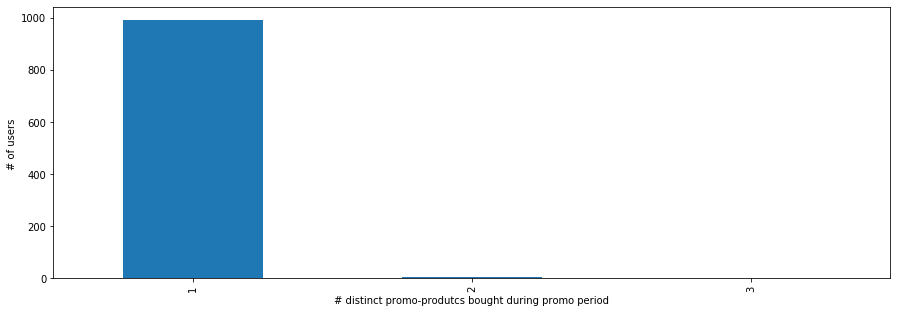

In [51]:
stats_df = df_promo.groupby("CUST_ID")["ARTICLE_ID"].apply(set).apply(len).to_frame().sort_values("ARTICLE_ID",ascending=False)["ARTICLE_ID"].value_counts()
ICD.display(stats_df.to_frame())

ax = stats_df.plot.bar(figsize=(15,5))
ax.set_xlabel("# distinct promo-produtcs bought during promo period")
ax.set_ylabel("# of users ")

In [55]:
stats_df = df_promo.groupby("ARTICLE_ID")["CUST_ID"].apply(list).apply(len).sort_values(0,ascending=False).to_frame().reset_index()

In [88]:
df_promo["ARTICLE_ID"]  = df_promo.apply(lambda x : le.inverse_transform([x.ARTICLE_ID])[0],axis=1)

Text(0, 0.5, '#Users')

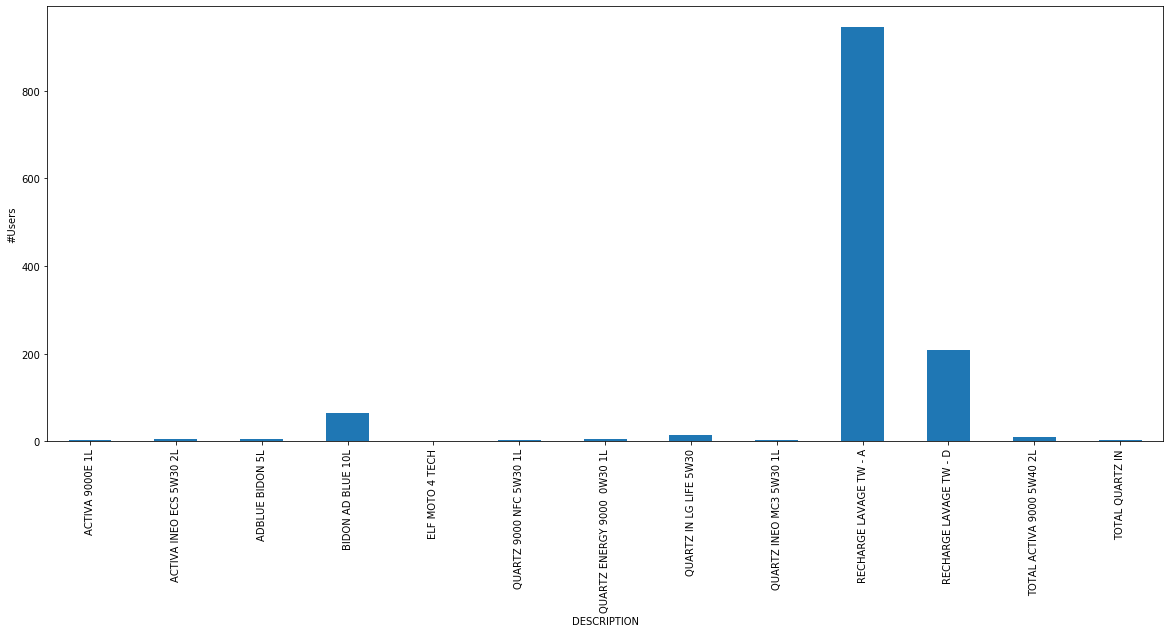

In [135]:
df_promo= df_promo.merge(items,on='ARTICLE_ID')
stats_df =  df_promo.groupby("DESCRIPTION").apply(len)
ax  = stats_df.plot.bar(figsize=(20,8),)
ax.set_xlabel("DESCRIPTION")
ax.set_ylabel("#Users")

In [141]:
stats_df= stats_df.sort_values("Users_Count",ascending=False)
stats_df.columns = ["DESCRIPTION", "Users_Count"]
stats_df

,DESCRIPTION,Users_Count
0,RECHARGE LAVAGE TW - A,946
1,RECHARGE LAVAGE TW - D,208
2,BIDON AD BLUE 10L,64
3,QUARTZ IN LG LIFE 5W30,14
4,TOTAL ACTIVA 9000 5W40 2L,10
5,ADBLUE BIDON 5L,6
6,QUARTZ ENERGY 9000 0W30 1L,4
7,ACTIVA INEO ECS 5W30 2L,4
8,QUARTZ INEO MC3 5W30 1L,3
9,QUARTZ 9000 NFC 5W30 1L,3


In [17]:
df.CUST_ID.nunique()

32160